## Load Output of network

In [1]:
## Load .nc file
import torch
import xarray as xr

# Input Data path here:
data_path = 'output.nc'
# Load data
data = xr.open_dataset(data_path)

# Get data
pred = data['prediction']
true = data['true']
input = data['inputs']

# Convert to torch tensor
pred = torch.tensor(pred.values)
true = torch.tensor(true.values)
input = torch.tensor(input.values)

# Stats of true and pred
print("pred mean: ", pred.mean(axis=(0,2,3)))
print("pred std: ", pred.std(axis=(0,2,3)))

print("true mean: ", true.mean(axis=(0,2,3)))
print("true std: ", true.std(axis=(0,2,3)))


U = input[:, :2 ]
V = input[:, 2:]

num_samples = pred.shape[0]
# Print shape
print("prediction shape: ", pred.shape)
print("true shape: ", true.shape)
print("input shape: ", input.shape)


print("U shape: ", U.shape)
print("V shape: ", V.shape)

# Close the file
data.close()

/home/exouser/anaconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pred mean:  tensor([ 1.4786e-15, -1.5877e-17])
pred std:  tensor([2.6906e-12, 9.6127e-15])
true mean:  tensor([-7.3443e-23, -7.3999e-25])
true std:  tensor([2.7699e-12, 1.0254e-14])
prediction shape:  torch.Size([2250, 2, 64, 64])
true shape:  torch.Size([2250, 2, 64, 64])
input shape:  torch.Size([2250, 4, 64, 64])
U shape:  torch.Size([2250, 2, 64, 64])
V shape:  torch.Size([2250, 2, 64, 64])


(0.0, 100.0)

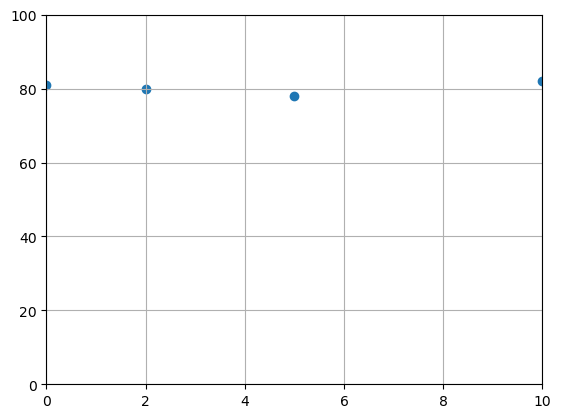

In [6]:
import torch
import matplotlib.pyplot as plt

x = torch.tensor([0, 2, 2, ])
y = torch.tensor([81, 80, 2])


plt.scatter(x,y)
plt.grid()
plt.xlim(0, 10)
plt.ylim(0, 100)

## Show some snapshots:

mean corr:  tensor(inf)
max corr:  tensor(inf)
min corr:  tensor(inf)
std corr:  tensor(nan)
tensor([inf, inf, inf,  ..., inf, inf, inf])
nan values index:  tensor([], size=(0, 1), dtype=torch.int64)


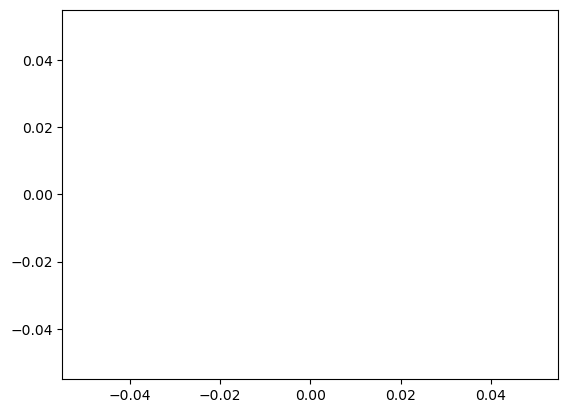

In [2]:
from utils.create_contour_plot import create_contour_plot
from utils.corr2 import corr2
import torch
import matplotlib.pyplot as plt

index = 40
channel = 0
scale = 1e0

cc = torch.zeros(num_samples)

for i in range(num_samples):
    index = i
    channel = 1
    
    cc[i] = corr2(true[index, channel]*scale, pred[index, channel]*scale)

# Take the mean of the correlation which is not inf or nan
# cc = cc[~torch.isinf(cc)]
# cc = cc[~torch.isnan(cc)]

# Print the mean, max, min correlation
print("mean corr: ", cc.mean())
print("max corr: ", cc.max())
print("min corr: ", cc.min())
print("std corr: ", cc.std())
print(cc)
plt.plot(cc)
# Printing the nan values index
print("nan values index: ", torch.isnan(cc).nonzero())

## Raw Data

{"nx": 64, "dt": 3600.0, "tmax": 311040000.0, "tavestart": 155520000.0, "rek": 3.5e-08, "delta": 0.05, "beta": 5e-12}


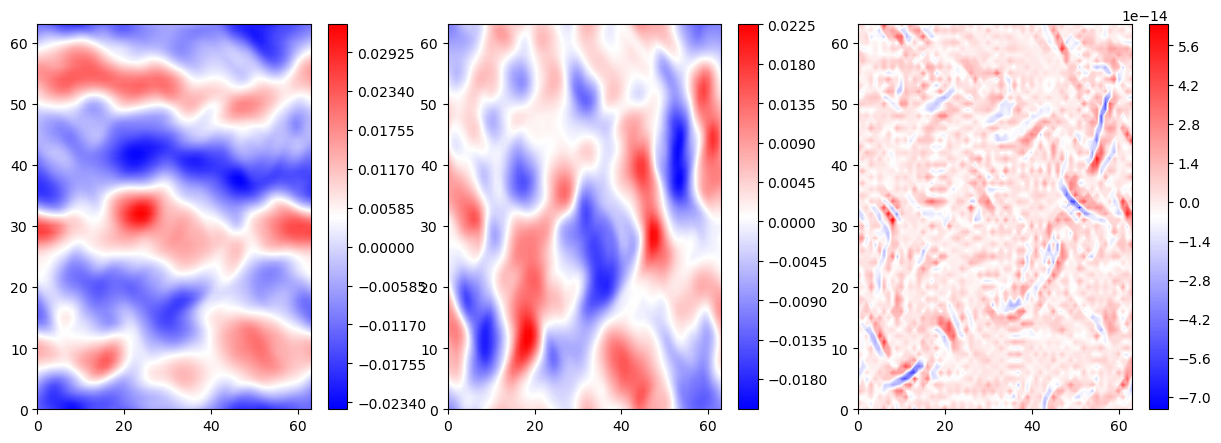

In [3]:
# Load raw data:
import matplotlib.pyplot as plt

raw = xr.open_dataset("/media/volume/sdc/data_qg/3jet/122.nc")

u = raw['u']
v = raw['v']
q = raw['q_forcing_advection']

print(raw.pyqg_params)
# Convert torch tensor
u = torch.tensor(u.values)
v = torch.tensor(v.values)
q = torch.tensor(q.values)

cc_inter = torch.zeros(87)
for i in range(87):
    cc_inter[i] = corr2(q[0,0], q[i,0])

# contour of raw data 3 x 1 with colorbar
index = 69
channel = 1
fix, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].contourf(u[index,channel], cmap='bwr', levels=400)
ax[1].contourf(v[index,channel], cmap='bwr', levels=400)
ax[2].contourf(q[index,channel], cmap='bwr', levels=400)
# set colorbar for ax[2]
plt.colorbar(ax[0].contourf(u[index,channel], cmap='bwr', levels=400), ax=ax[0])
plt.colorbar(ax[1].contourf(v[index,channel], cmap='bwr', levels=400), ax=ax[1])
plt.colorbar(ax[2].contourf(q[index,channel], cmap='bwr', levels=400), ax=ax[2])

In [10]:
def spectrum_xy_averaged_2D(A, direction, spectral=False):
    Nx = A.shape[0]
    Ny = A.shape[1]

    # Generating wavenumbers
    L = 2 * torch.pi
    kx = 2 * torch.pi * torch.fft.fftfreq(Nx, d=L/Nx)
    ky = 2 * torch.pi * torch.fft.fftfreq(Ny, d=L/Ny)
    wavenumber_x, wavenumber_y = torch.meshgrid(kx, ky)

    if spectral:
        A_hat = A
    else:
        A_hat = torch.fft.fft2(A)

    # Taking abs and fftshift
    A_hat = torch.abs(A_hat)
    A_hat = torch.fft.fftshift(A_hat)

    if direction[0] == 1 and direction[1] == 0:
        A_hat_mean = A_hat.mean(axis=1)
        # A_spec = torch.flip(A_hat_mean[:Ny//2]/Ny, [0])
        A_spec = torch.flip(A_hat_mean[:Ny//2], [0])
        wavenumbers = torch.arange(0, Nx // 2)
    elif direction[0] == 0 and direction[1] == 1:
        A_hat_mean = A_hat.mean(axis=0)
        # A_spec = torch.flip(A_hat_mean[:Nx//2]/Nx, [0])
        A_spec = torch.flip(A_hat_mean[:Nx//2], [0])
        wavenumbers = torch.arange(0, Ny // 2)
    else:
        raise ValueError('Direction must be [1,0] or [0,1]')
    
    return A_spec, wavenumbers

/tmp/ipykernel_756641/1495666734.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  plt.plot(kq, model_spec.mean(axis=0).T, label='model')


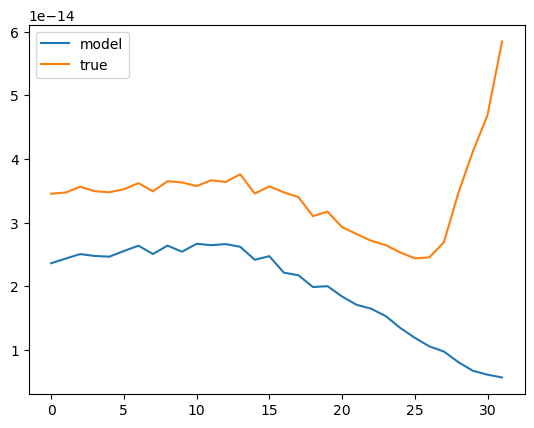

In [12]:
# Converting to torch


q_spec = torch.zeros((87, 32))
model_spec = torch.zeros((87, 32))
true_spec = torch.zeros((87, 32))
# Convert xarray to torch tensor

for i in range(7):

    q_spec[i], kq = spectrum_xy_averaged_2D(q[i,0], [0,1])
    model_spec[i], km = spectrum_xy_averaged_2D(pred[i,1], [1,0])
    true_spec[i], kt = spectrum_xy_averaged_2D(true[i,1], [1,0])



plt.plot(kq, model_spec.mean(axis=0).T, label='model')
plt.plot(kq, true_spec.mean(axis=0).T, label='true')
plt.legend()
plt.show()